In [1]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import zscore

In [2]:
name = '2021-11-12_18.39.23' # '2021-11-12_18.58.41'
dataset = 'waterbird'
dpath = f'./experiments/{dataset}/{name}/activations/'
es = ['0', '1', '2', '3']

# Get data
## Train
Landbirds are class 0, waterbirds class 1

In [3]:
trainenvsx = []
trainenvsy = []
for e in es:
    with open(dpath + f'activations_id_at_epoch_30_e{e}.npy', 'rb') as f:
        cl = int(e)//2 # this group's class
        trainenvsx.append(np.load(f))
        ne = trainenvsx[-1].shape[0] # num examples of this group
        trainenvsy.append(np.array([cl] * ne))
        print(e, trainenvsx[-1].shape)

0 (3310, 512)
1 (368, 512)
2 (112, 512)
3 (1005, 512)


In [4]:
# xtrain_mask = np.concatenate([trainenvsx[0][:, 200:300], trainenvsx[3][:, 200:300]])
xtrain = np.concatenate(trainenvsx)
ytrain = np.concatenate(trainenvsy)
print(xtrain.shape, ytrain.shape)

(4795, 512) (4795,)


### Plotting

In [5]:
std = []
mean = []
for e in trainenvsx:
    mean.append(e.mean(axis=0))
    std.append(e.std(axis=0))
order = np.argsort(trainenvsx[0].mean(axis=0))

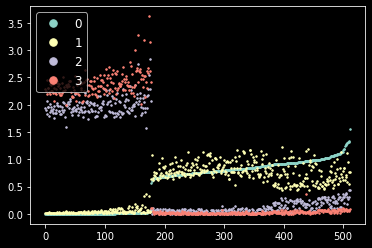

In [6]:
for i, m in enumerate(mean):
    plt.plot(range(512), m[order], 'o', ms=1.5, label=i)

plt.legend(loc="upper left", markerscale=5, fontsize=12)

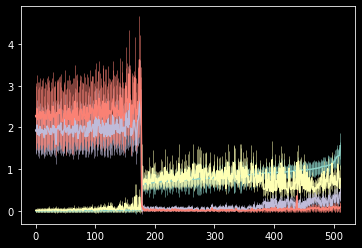

In [7]:
for e in range(4):
    plt.errorbar(range(512), mean[e][order], yerr = std[e][order], elinewidth=0.5)

## Test data

In [8]:
testenvsx = []
testenvsy = []
for e in es:
    with open(dpath + f'test/activations_id_at_epoch_30_e{e}.npy', 'rb') as f:
        cl = int(e)//2 # this group's class
        testenvsx.append(np.load(f))
        ne = testenvsx[-1].shape[0] # num examples of this group
        testenvsy.append(np.array([cl] * ne))
        print(e, testenvsx[-1].shape)

0 (2255, 512)
1 (2255, 512)
2 (642, 512)
3 (642, 512)


In [9]:
# xtest_mask = np.concatenate([testenvsx[0][:, 200:300], testenvsx[3][:, 200:300]])
xtest = np.concatenate(testenvsx)
ytest = np.concatenate(testenvsy)
print(xtest.shape, ytest.shape)

(5794, 512) (5794,)


# Models
## Ordinary LinReg
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [59]:
reg = LinearRegression(normalize=True).fit(xtrain, ytrain)
reg.score(xtrain, ytrain)

0.9919997869945102

In [60]:
reg.score(xtest, ytest)

0.5743888210158071

## Ridge
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier

In [45]:
from sklearn.linear_model import RidgeClassifier

In [81]:
rdg = RidgeClassifier(alpha=0.2).fit(xtrain, ytrain)
rdg.score(xtrain, ytrain)

/u/s/o/sonic/miniconda3/envs/spood/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.30659e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


1.0

In [82]:
rdg.score(xtest, ytest)

0.9109423541594753

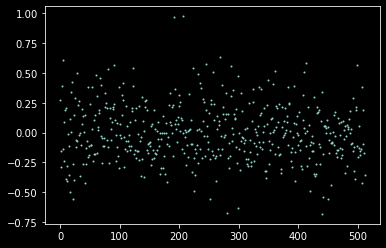

In [83]:
plt.plot(range(512), rdg.coef_.T[order], 'o', ms=1)

## LogReg
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
log = LogisticRegression(penalty='l2').fit(xtrain, ytrain)
log.score(xtrain, ytrain)

1.0

In [12]:
log.score(xtest, ytest)

0.8986882982395582

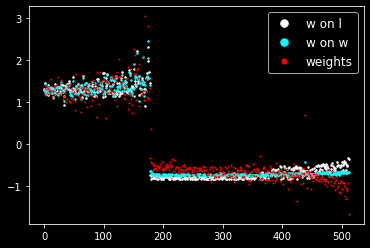

In [13]:
plt.plot(range(512), zscore(mean[2])[order], 'o', ms=1.5, color='white', label='w on l')
plt.plot(range(512), zscore(mean[3])[order], 'o', ms=1.5, color='aqua', label='w on w')
plt.plot(range(512), zscore(log.coef_.T)[order], 'o', ms=1, color='red', label='weights')
plt.legend(loc="upper right", markerscale=5, fontsize=12)

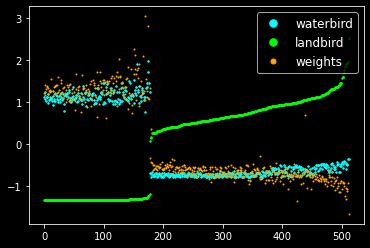

In [34]:
plt.plot(range(512), mcw[order], 'o', ms=1.5, color='aqua', label='waterbird')
plt.plot(range(512), mcl[order], 'o', ms=1.5, color='lime', label='landbird')
plt.plot(range(512), zscore(log.coef_.T)[order], 'o', ms=1, color='orange', label='weights')
plt.legend(loc="upper right", markerscale=5, fontsize=12)

## PCA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [102]:
from sklearn.decomposition import PCA

In [106]:
pca = PCA(n_components=3).fit(xtrain)
pca.explained_variance_ratio_

array([0.9403257 , 0.02893361, 0.02344243], dtype=float32)

# Confirm that the model is already paying attention to these units

In [21]:
import torch
from models.resnet import load_model

In [22]:
model = load_model()

ResNet Loading Done


In [23]:
cpt_path = f"./experiments/{dataset}/{name}/checkpoints/checkpoint_30.pth.tar"
checkpoint = torch.load(cpt_path)
state_dict = checkpoint['state_dict_model']

In [24]:
new_state_dict = {}
for k, v in state_dict.items():
    k = k.replace("module.", "")
    new_state_dict[k] = v
state_dict = new_state_dict

In [25]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [26]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),

In [27]:
w = model.linear.weight.detach().numpy()
w.shape

(2, 512)

In [14]:
def ztrans(means, stds):
    m = means.mean()
    s = means.std()
    meanstrans = (means-m) / s
    stdstrans = stds / s
    return meanstrans, stdstrans

In [15]:
m0, s0 = ztrans(mean[0], std[0])
m1, s1 = ztrans(mean[1], std[1])
m2, s2 = ztrans(mean[2], std[2])
m3, s3 = ztrans(mean[3], std[3])
mcw, scw = ztrans(np.concatenate(mean[2:]), np.concatenate(std[2:]))
mcl, scl = ztrans(np.concatenate(mean[:2]), np.concatenate(std[:2]))

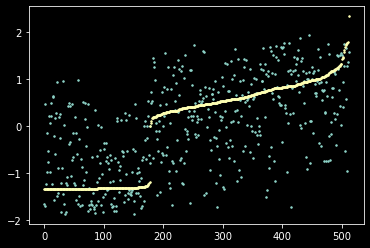

In [28]:
plt.plot(range(512), zscore(w[0])[order], 'o', ms=1.5)
plt.plot(range(512), zscore(mean[0])[order], 'o', ms=1.5)

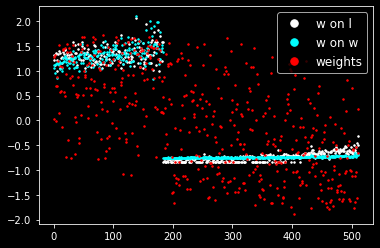

In [124]:
plt.plot(range(512), zscore(mean[2])[order], 'o', ms=1.5, color='white', label='w on l') # caution: z scores don't line up for group 2 and 3
plt.plot(range(512), zscore(mean[3])[order], 'o', ms=1.5, color='aqua', label='w on w')
plt.plot(range(512), zscore(w[1])[order], 'o', ms=1.5, color='red', label='weights')
plt.legend(loc="upper right", markerscale=5, fontsize=12)

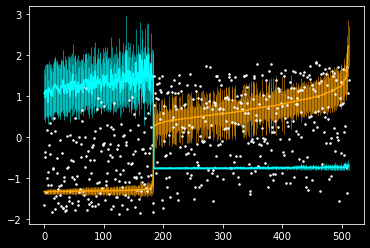

In [24]:
plt.errorbar(range(512), m0[order], yerr = s0[order], elinewidth=0.5, color='orange')
plt.errorbar(range(512), m3[order], yerr = s3[order], elinewidth=0.5, color='aqua')
plt.plot(range(512), zscore(w[0])[order], 'o', ms=1.5, color='white')

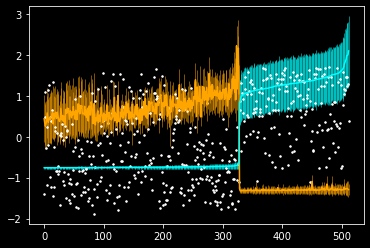

In [25]:
order3 = np.argsort(mean[3])
plt.errorbar(range(512), m0[order3], yerr = s0[order3], elinewidth=0.5, color='orange')
plt.errorbar(range(512), m3[order3], yerr = s3[order3], elinewidth=0.5, color='aqua')
plt.plot(range(512), zscore(w[1])[order3], 'o', ms=1.5, color='white')

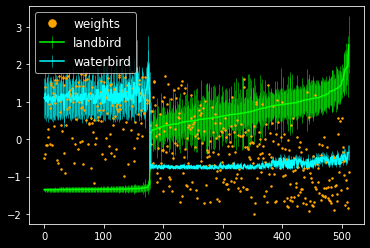

In [45]:
plt.plot(range(512), zscore(w[1])[order], 'o', ms=1.5, color='orange', label='weights')
plt.errorbar(range(512), mcl[order], yerr = scl[order], elinewidth=0.5, color='lime', label='landbird')
plt.errorbar(range(512), mcw[order], yerr = scw[order], elinewidth=0.5, color='aqua', label='waterbird')
plt.legend(loc="upper left", markerscale=5, fontsize=12)

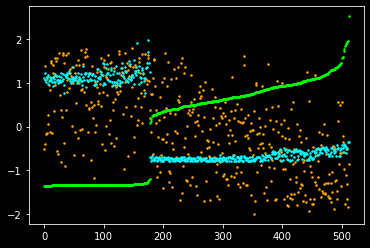

In [46]:
plt.plot(range(512), zscore(w[1])[order], 'o', ms=1.5, color='orange', label='weights')
plt.plot(range(512), mcl[order], 'o', ms=1.5, color='lime', label='landbird')
plt.plot(range(512), mcw[order], 'o', ms=1.5, color='aqua', label='waterbird')
# plt.legend(loc="upper left", markerscale=5, fontsize=12)